     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Saving news_sentiment_corrected_verified_fully_balanced.csv to news_sentiment_corrected_verified_fully_balanced.csv


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Weighted,F1 Macro
300,0.500000,0.420146,0.858790,0.799487,0.709646,0.843884,0.711058
600,0.208200,0.302414,0.904899,0.877133,0.848511,0.903210,0.847963
900,0.110600,0.402462,0.893372,0.838155,0.862358,0.894469,0.841501
1200,0.063900,0.321273,0.925072,0.882908,0.889959,0.924681,0.882489


{'eval_loss': 0.34890466928482056, 'eval_accuracy': 0.9221902017291066, 'eval_precision': 0.8725632281898267, 'eval_recall': 0.9014307148215625, 'eval_f1_weighted': 0.9229452509579357, 'eval_f1_macro': 0.8832981307947841, 'eval_runtime': 9.4718, 'eval_samples_per_second': 36.635, 'eval_steps_per_second': 4.645, 'epoch': 8.0}
{'sentiment': 'Neutral', 'confidence': 0.971}
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        56
           1       0.97      0.93      0.95       248
           2       0.85      0.79      0.82        43

    accuracy                           0.92       347
   macro avg       0.87      0.90      0.88       347
weighted avg       0.93      0.92      0.92       347



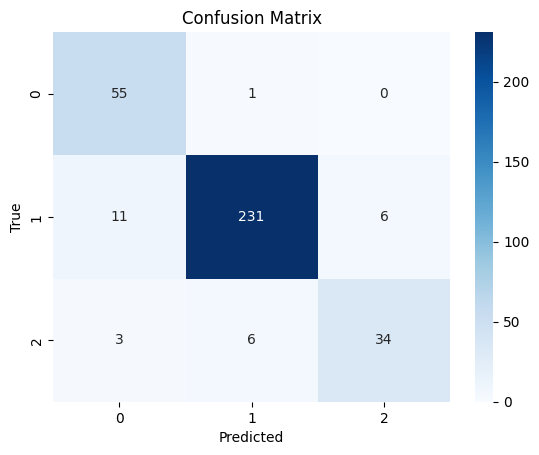

In [ ]:
# --- Install necessary packages ---
!pip install transformers datasets torch scikit-learn fastapi uvicorn streamlit seaborn safetensors

# --- Import required libraries ---
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from datasets import Dataset as HFDataset
from torch.utils.data import Dataset
import random

# --- Seed control for reproducibility ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Check available device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load the VERIFIED dataset and drop NaN values ---
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("news_sentiment_corrected_verified_fully_balanced.csv")
df.dropna(subset=["Description", "verified_sentiment"], inplace=True)

# --- Text preprocessing ---
df["cleaned_text"] = df["Description"].astype(str).str.lower()

# --- Sentiment mapping ---
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
df["verified_sentiment"] = df["verified_sentiment"].str.lower().map(sentiment_mapping)
df.dropna(subset=["verified_sentiment"], inplace=True)

# --- Prepare texts and labels ---
labels = df["verified_sentiment"].tolist()
texts = df["cleaned_text"].tolist()

# --- Tokenizer ---
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# --- Train/test split ---
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# --- Tokenize ---
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=512)
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=512)

# --- Dataset class ---
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: torch.tensor(v, dtype=torch.long) for k, v in encodings.items()}
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

# --- Create datasets ---
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# --- Model config with lower dropout ---
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3, hidden_dropout_prob=0.2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config).to(device)

# --- TrainingArguments with lower learning rate ---
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=300,
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"
)

# --- Metrics ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

# --- Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# --- Train ---
trainer.train()

# --- Evaluate ---
metrics = trainer.evaluate()
print(metrics)

# --- Save model and tokenizer ---
model.save_pretrained("./bert_sentiment_model_verified")
tokenizer.save_pretrained("./bert_sentiment_model_verified")

# --- Predict Function ---
def predict_sentiment(text: str):
    tokenizer = BertTokenizer.from_pretrained("./bert_sentiment_model_verified")
    model = BertForSequenceClassification.from_pretrained("./bert_sentiment_model_verified").to(device)
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    pred_label = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_label].item()
    return {"sentiment": label_map[pred_label], "confidence": round(confidence, 4)}

# --- Example prediction ---
print(predict_sentiment("The economy is booming and people are happy!"))

# --- Confusion Matrix ---
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
print(classification_report(test_labels, y_pred))

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


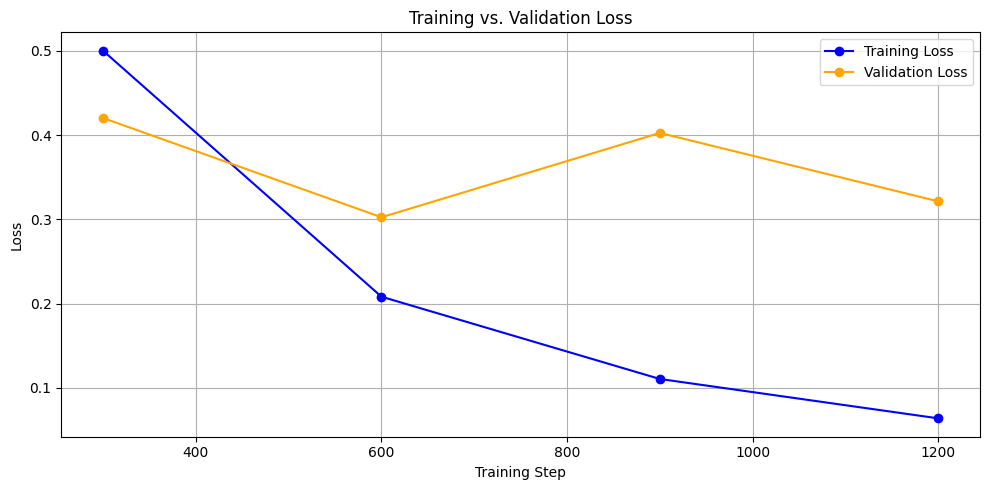

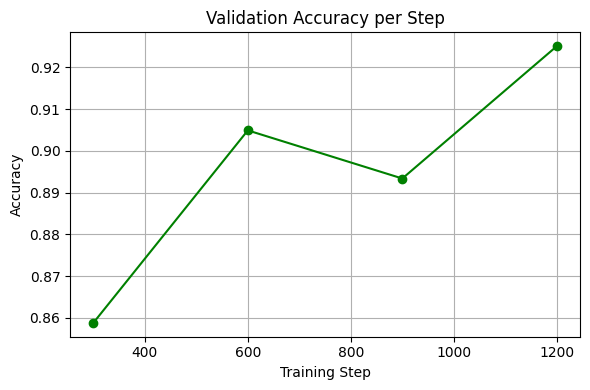

In [ ]:
import matplotlib.pyplot as plt

# Step-wise values
steps = [300, 600, 900, 1200]
train_loss = [0.500000, 0.208200, 0.110600, 0.063900]
val_loss = [0.420146, 0.302414, 0.402462, 0.321273]
accuracy = [0.858790, 0.904899, 0.893372, 0.925072]

# Plot
plt.figure(figsize=(10, 5))

# Loss Plot
plt.plot(steps, train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(steps, val_loss, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy Plot
plt.figure(figsize=(6, 4))
plt.plot(steps, accuracy, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Step')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from tabulate import tabulate
import numpy as np

# Load tokenizer and model from local path
model_path = "/content/bert_sentiment_model_verified"
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Label mapping
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Define batch prediction function with full confidence scores
def predict_multiple_sentiments_full_confidence(texts):
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()
            pred_id = np.argmax(probs)
            result = {
                "text": text,
                "predicted": id2label[pred_id],
                "confidence_predicted": round(probs[pred_id], 4),
                "conf_negative": round(probs[0], 4),
                "conf_neutral": round(probs[1], 4),
                "conf_positive": round(probs[2], 4)
            }
            results.append(result)
    return results

# Combined News Headlines
texts = [

    "Israel accuses Hamas of trying to 'hide' the results of its airstrike which killed 'at least 90 people' while targeting October 7 mastermind Mohammed Deif - as the terrorist group insists its military chief is in good health",
    "Global Economy Shows Signs of Recovery as Job Market Improves",
    "Five Indian storytellers for captivating and entertaining storytelling",
    "Promotion for infielder Brooks Baldwin among flurry of White Sox moves coming out of All-Star break",
    "New Study Shows Exercise Boosts Mental Health and Well-Being",

    # New Positive
    "Tech Company Announces Record Profits in Q1",
    "Scientists Discover New Renewable Energy Source",
    "New Vaccine Shows 95% Efficacy in Trials",

    # New Neutral
    "City Council Schedules Meeting for Budget Discussion",
    "Temperature Expected to Rise Slightly Over the Weekend",
    "Annual Tech Conference Opens with Keynote Speech",
    "Local Library Hosts Summer Reading Program",

    # New Negative
    "Earthquake in Turkey Leaves Hundreds Homeless",

    "Oil Spill Threatens Marine Wildlife",
    "Protesters Clash With Police Over New Law",

    # Tricky Positives (may be misclassified as Neutral)
    "Renewable energy jobs rise globally, says new report",

    # Tricky Neutrals (may be seen as Positive)
    "Scientists announce findings in solar panel efficiency study",
    "NASA schedules new mission to study asteroid samples",
    "University to host AI ethics conference next month",

    # Tricky Negatives (soft language, but serious events)
    "Inflation concerns persist despite economic recovery signs",
    "Climate report warns of increasing natural disasters",
    "War-torn region sees tentative ceasefire amid unrest"
]

# Expected Sentiments
expected_sentiments = [
     "Negative", "Positive", "Neutral", "Neutral", "Positive",

    # New Positive
    "Positive", "Positive", "Positive",

    # New Neutral
    "Neutral", "Neutral", "Neutral", "Neutral",

    # New Negative
    "Negative", "Negative", "Negative",

    # Tricky Positive
     "Positive",

    # Tricky Neutral
    "Neutral", "Neutral", "Neutral",

    # Tricky Negative
    "Negative", "Negative", "Negative"
]

# Predict
results = predict_multiple_sentiments_full_confidence(texts)

# Format results
df = pd.DataFrame(results)
df["Expected"] = expected_sentiments
df = df[["text", "Expected", "predicted", "confidence_predicted", "conf_negative", "conf_neutral", "conf_positive"]]
df.columns = ["Text (Shortened)", "Expected", "Predicted", "Conf (Pred)", "Conf (Neg)", "Conf (Neu)", "Conf (Pos)"]
df["Text (Shortened)"] = df["Text (Shortened)"].str.slice(0, 60) + "..."

# Display in table format
print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))


╒═════════════════════════════════════════════════════════════════╤════════════╤═════════════╤═══════════════╤══════════════╤══════════════╤══════════════╕
│ Text (Shortened)                                                │ Expected   │ Predicted   │   Conf (Pred) │   Conf (Neg) │   Conf (Neu) │   Conf (Pos) │
╞═════════════════════════════════════════════════════════════════╪════════════╪═════════════╪═══════════════╪══════════════╪══════════════╪══════════════╡
│ Israel accuses Hamas of trying to 'hide' the results of its ... │ Negative   │ Negative    │        0.9958 │       0.9958 │       0.0015 │       0.0027 │
├─────────────────────────────────────────────────────────────────┼────────────┼─────────────┼───────────────┼──────────────┼──────────────┼──────────────┤
│ Global Economy Shows Signs of Recovery as Job Market Improve... │ Positive   │ Positive    │        0.9918 │       0.0063 │       0.0019 │       0.9918 │
├───────────────────────────────────────────────────────────────

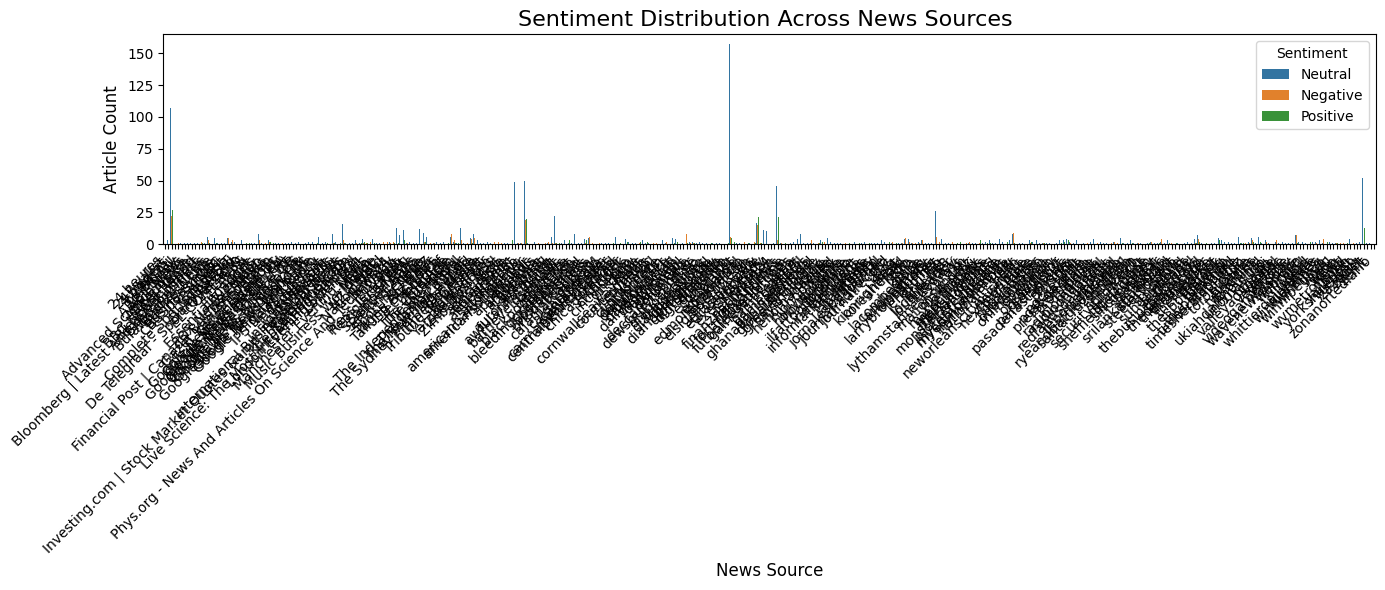

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load the dataset ---
df = pd.read_csv("news_sentiment_corrected_verified_fully_balanced.csv")

# --- Clean and preprocess ---
df = df.dropna(subset=["Description", "verified_sentiment", "Source"])
df["verified_sentiment"] = df["verified_sentiment"].str.lower()
df["verified_sentiment"] = df["verified_sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Optional: map back to label names for better plot readability
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df["Sentiment Label"] = df["verified_sentiment"].map(label_map)

# --- Group by Source and Sentiment ---
sentiment_dist = df.groupby(["Source", "Sentiment Label"]).size().reset_index(name="Count")

# --- Plotting ---
plt.figure(figsize=(14, 6))
sns.barplot(data=sentiment_dist, x="Source", y="Count", hue="Sentiment Label")
plt.title("Sentiment Distribution Across News Sources ", fontsize=16)
plt.xlabel("News Source", fontsize=12)
plt.ylabel("Article Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
